In [1]:
import sys
sys.path.append('..')

import numpy as np
from scipy import linalg

from matplotlib import pyplot as plt
%matplotlib inline

from filters import ExtendedKalmanFilter
from smoothers import ExtendedKalmanSmoother 
from util import feval

_reseed = True

# Extended Kalman Filter Demo


...

### Predict
$x_{t|t-1} = f(x_{t-1}, u_t)$

$P_{t|t-1} = \mathbf{F}_x(x_{t-1})P_{t-1}\mathbf{F}_x(x_{t-1})^\text{T} + \mathbf{F}_q(x_{t-1})\mathbf{Q}_t\mathbf{F}_q(x_{t-1})^\text{T}$

Where $\mathbf{F}_x(x) = \left.\frac{\partial f_j}{\partial x_i}\right|_x$ and $\mathbf{F}_q(x) = \left.\frac{\partial f_j}{\partial \xi_i}\right|_x$ are the Jacobians of $f(\cdot)$ with respect to the state and noise respectively.

### Update

$\mathbf{K}_t = P_{t|t-1}\mathbf{H}_x(x_{t|t-1})^\text{T} \left( \mathbf{H}_x(x_{t|t-1}) P_{t|t-1}\mathbf{H}_x(x_{t|t-1})^\text{T} + \mathbf{H}_r(x_{t|t-1})\mathbf{R}_t\mathbf{H}_r(x_{t|t-1})^\text{T}\right)^{-1}$

$x_{t|t} = x_{t|t-1} + \mathbf{K}_t(y_t - h(x_{t|t-1}, u_t))$

$P_{t|t} = P_{t|t-1} - \mathbf{K}_t\left(\mathbf{H}_x(x_{t|t-1}) P_{t|t-1}\mathbf{H}_x(x_{t|t-1})^\text{T} + \mathbf{H}_r(x_{t|t-1})\mathbf{R}_t\mathbf{H}_r(x_{t|t-1})^\text{T}\right)\mathbf{K}^T$

Where $y_t$ is the measured observation at time $t$, and $\mathbf{H}_x(x) = \left.\frac{\partial h_j}{\partial x_i}\right|_x$ and $\mathbf{H}_q(x) = \left.\frac{\partial h_j}{\partial \nu_i}\right|_x$ are the Jacobians of $h(\cdot)$ with respect to the state and noise respectively.

## 1-D Example

...

$x_t = \left[\theta_t, \omega_t, a_t\right]^\text{T}$ and $y_t = [x]$

The respective process models are:

$f(\cdot) = \begin{bmatrix}\theta_t + \omega_t \\ \omega_t \\ a_t\end{bmatrix} \qquad h(\cdot) = a_t\sin\theta_t$

The Jacobian for $f$ w.r.t. the state is $\mathbf{F}_x = \begin{bmatrix}1 & 1 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix}$

The Jacobian for $h$ w.r.t. the state is $\mathbf{H}_x = \begin{bmatrix}a_t\cos\theta_t & 0 & \sin\theta_t\end{bmatrix}$

The input control is not used.

In [2]:
# Number of observations
n_t = 500
# Time interval
dt = 5./n_t

# Process model
f = lambda x: np.array([[x[0,0] + dt*x[1,0], x[1,0], x[2,0]]]).T
Fx = lambda x: np.array([[1., dt, 0.], [0., 1., 0.], [0., 0., 1.]])

# Observation model
h = lambda x: x[2,0] * np.sin(x[0,0])
# Jacobian
Hx = lambda x: np.array([[x[2,0]*np.cos(x[0,0]), 0., np.sin(x[0,0])]])

some text

In [3]:
# Process noise covariance
Q = np.array([[0.2*(dt**3)/3., 0.2*(dt**2)/2, 0],[0.2*(dt**2)/2, 0.2*dt, 0], [0, 0, 0.1*dt]])

# Observation noise covariance
R = np.array([[1]])

# Initial state and estimation error covariance
x0 = np.array([[0., 10. , 1.]]).T
P0 = np.diag(np.array([2., 3., 1.]))#3. * np.eye(x0.shape[0])

print(P0)
# Data dimensions
n_x = 3
n_y = 1

[[ 2.  0.  0.]
 [ 0.  3.  0.]
 [ 0.  0.  1.]]


Model the systems

1515236338


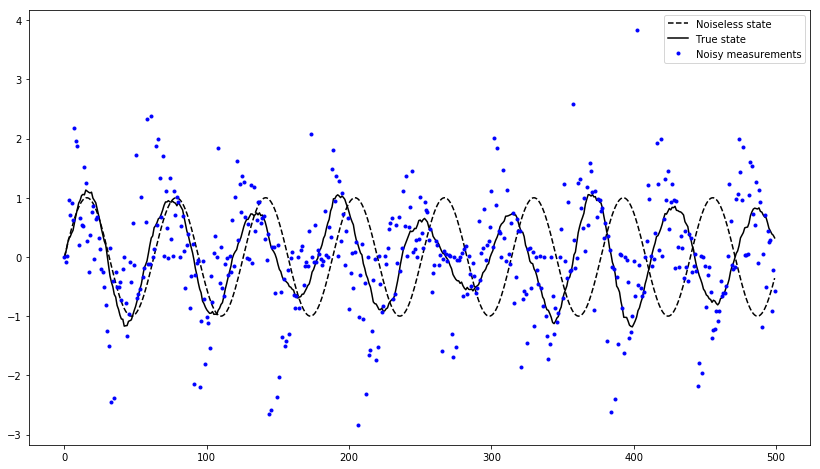

In [4]:
if _reseed:
    seed = np.random.randint(0, np.iinfo(np.int32).max)
    print(seed)
else:
    seed = 718592412
np.random.seed(seed)

# First model a perfect system
def sys_noiseless(x0, f, Q, h, R):
    n_x = x0.shape[0]
    
    x_noiseless = np.zeros((n_x, n_t))
    y_noiseless = np.zeros((R.shape[0], n_t))

    x_noiseless[:,0] = x0.ravel()
    y_noiseless[:,0] = feval(h, x0).ravel()

    for i_ in range(1,n_t):
        x_noiseless[:,i_] = feval(f, x_noiseless[:,i_-1].reshape(n_x,1)).ravel()
        y_noiseless[:,i_] = feval(h, x_noiseless[:,i_].reshape(n_x,1)).ravel()

    return x_noiseless, y_noiseless

x_noiseless, y_noiseless = sys_noiseless(x0, f, Q, h, R)

# A noisy system
def sys_noisy(x0, f, Q, h, R):
    """ Noisy system modelling"""
    n_x = x0.shape[0]
    n_y = R.shape[0]
    
    x_true  = np.zeros((n_x, n_t))
    y_true  = np.zeros((n_y, n_t))
    y_noisy = np.zeros((n_y, n_t))

    x_true[:,0] = x0.ravel()
    y_true[:,0] = feval(h,x0).ravel()
    y_noisy[:,0] = feval(h,x0).ravel() # no noise for first

    for i_ in range(1,n_t):
        x_true[:,i_] = feval(f, x_true[:,i_-1].reshape(n_x,1) + linalg.cholesky(Q) @ np.random.randn(n_x,1)).ravel()
        y_true[:,i_] = feval(h, x_true[:,i_].reshape(n_x,1)).ravel()
        y_noisy[:,i_] = feval(h, x_true[:,i_].reshape(n_x,1) + linalg.cholesky(R) @ np.random.randn(n_y,1)).ravel()
    
    return x_true, y_true, y_noisy

#
x_true, y_true, y_noisy = sys_noisy(x0, f, Q, h, R)


plt.figure(figsize=(14, 8))

plt.plot(y_noiseless.T, 'k--')
plt.plot(y_true.T, 'k-')
plt.plot(y_noisy.T,'b.')

plt.legend(labels=['Noiseless state', 'True state', 'Noisy measurements'])

In [5]:
ekf = ExtendedKalmanFilter(x0, P0, f, Q, Fx, None, h, R, Hx, None)

x_estimate = np.zeros_like(x_true)
P_estimate = np.zeros((n_x, n_x, n_t))
y_estimate = np.zeros_like(y_true)

x_estimate[:,0] = x0.ravel()
y_estimate[:,0] = feval(h, x0).ravel()
P_estimate[:,:,0] = P0

for i_ in range(1, n_t):
    ekf.predict()
    ekf.update(y_noisy[:,i_])
    x_estimate[:,i_] = ekf.state['expected'].ravel()
    P_estimate[:,:,i_] = ekf.state['err_cov']
    y_estimate[:,i_] = feval(h, x_estimate[:,i_].reshape(n_x,1)).ravel()

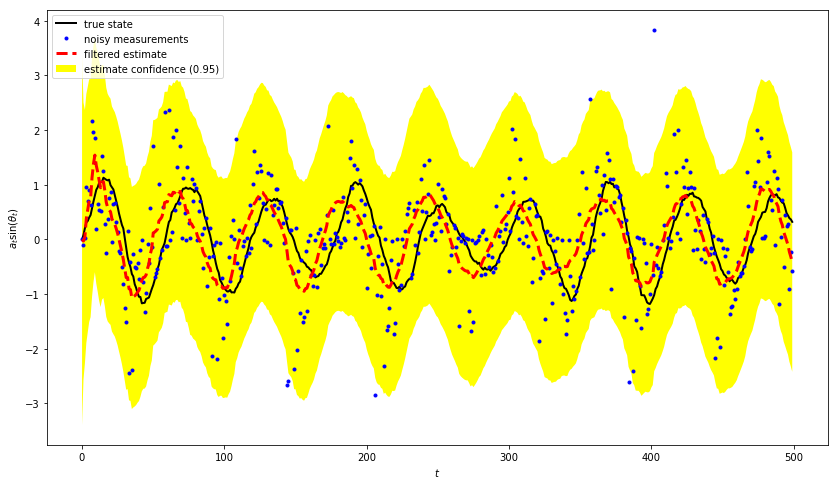

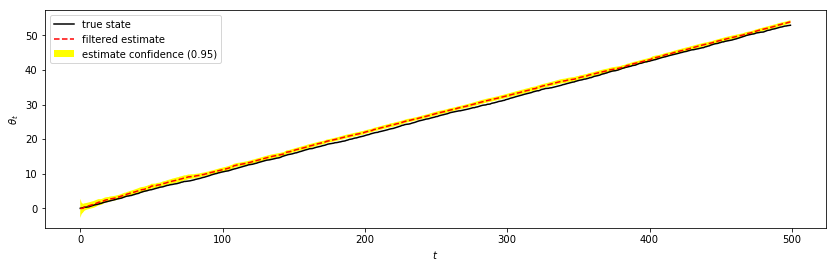

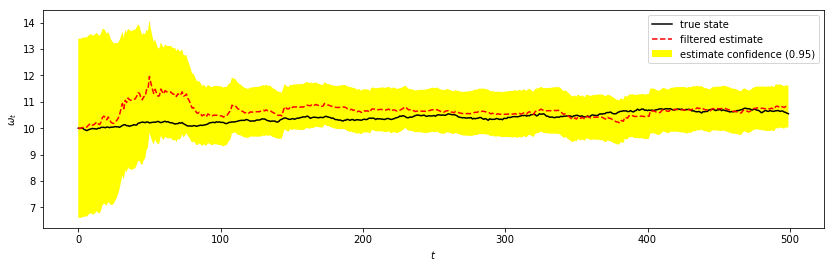

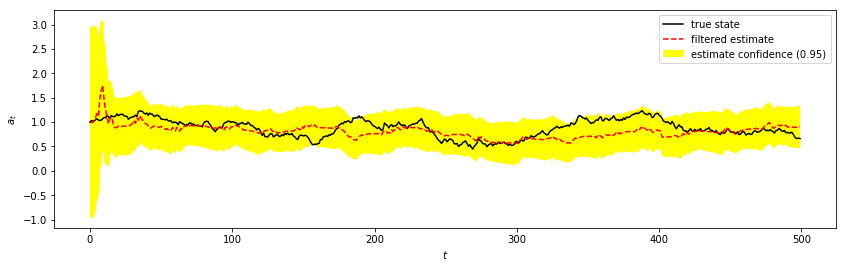

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-', lw=2)
plt.plot(y_noisy.T, 'b.')
plt.plot(y_estimate.T, 'r--', lw=3)

P_y = np.zeros((y_estimate.shape[0], y_estimate.shape[0], n_t))

for i in range(n_t):
    H_ = feval(Hx, x_estimate[:,i].reshape(x0.shape))
    P_y[:,:,i] = np.atleast_2d(H_ @ P_estimate[:,:,i] @ H_.T + R)
    
err = 1.96*np.sqrt(P_y[0,0,:].reshape(y_estimate.shape))

ymax = y_estimate.ravel() + err.ravel()
ymin = y_estimate.ravel() - err.ravel()

plt.fill_between(np.arange(n_t),ymax,ymin, facecolor='yellow', interpolate=True)

plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','noisy measurements','filtered estimate','estimate confidence (0.95)'])


lbl = [r'$\theta_t$',r'$\omega_t$',r'$a_t$']
for i in range(3):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i,:].ravel(),'k-')
    plt.plot(x_estimate[i,:].ravel(), 'r--')
    
    err = 1.96*np.sqrt(P_estimate[i,i,:].ravel())
    xmax = x_estimate[i,:].ravel() + err.ravel()
    xmin = x_estimate[i,:].ravel() - err.ravel()

    plt.fill_between(np.arange(n_t), xmax, xmin, facecolor='yellow', interpolate=True)
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])
    plt.legend(labels=['true state','filtered estimate','estimate confidence (0.95)'])

In [7]:
erts = ExtendedKalmanSmoother.from_filter(ekf)
states = erts.smooth()

x_smoothed = np.zeros_like(x_true)
P_smoothed = np.zeros((n_x, n_x, n_t))
y_smoothed = np.zeros_like(y_true)

x_smoothed[:,0] = x0.ravel()
y_smoothed[:,0] = feval(h, x0).ravel()
P_smoothed[:,:,0] = P0

for i_ in range(1, n_t):
    x_smoothed[:,i_] = states[i_]['expected'].ravel()
    P_smoothed[:,:,i_] = states[i_]['err_cov']
    y_smoothed[:,i_] = feval(h,x_smoothed[:,i_].reshape(n_x,1)).ravel()

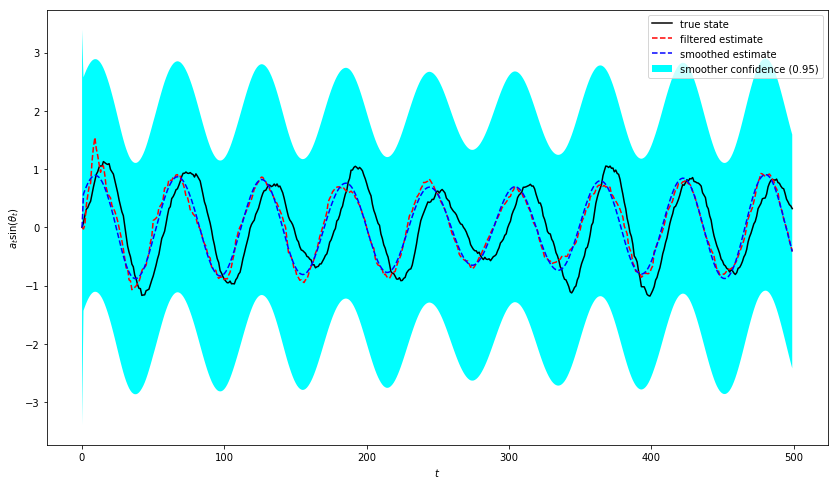

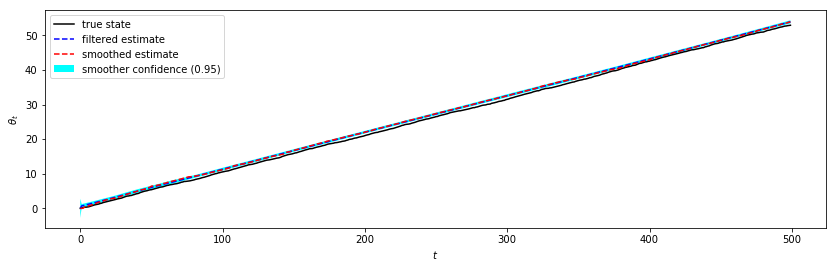

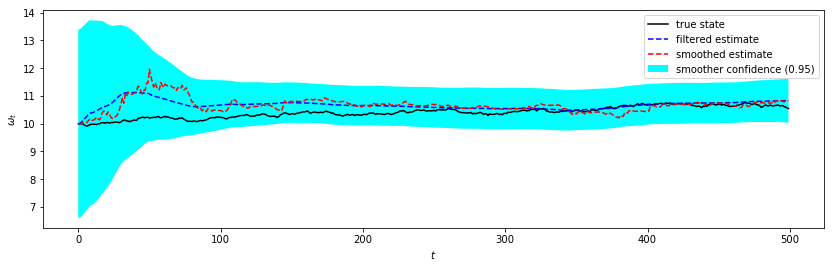

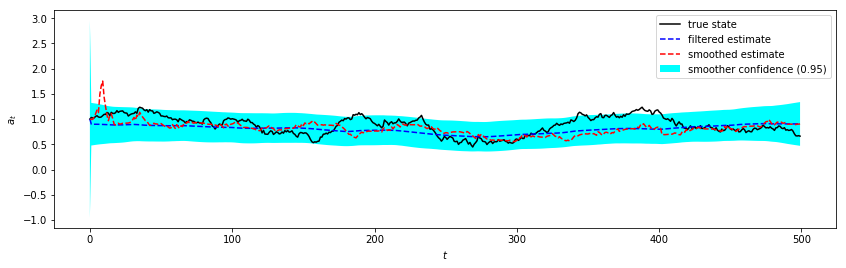

In [8]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_estimate.T, 'r--')
plt.plot(y_smoothed.T, 'b--')

P_y = np.zeros((y_estimate.shape[0], y_estimate.shape[0], n_t))

for i in range(n_t):
    H_ = feval(Hx, x_smoothed[:,i].reshape(x0.shape))
    P_y[:,:,i] = np.atleast_2d(H_ @ P_smoothed[:,:,i] @ H_.T + R)
    
err = 1.96*np.sqrt(P_y[0,0,:].reshape(y_smoothed.shape))

#err = 1.96*np.sqrt(P_smoothed[0,0,:].reshape(y_smoothed.shape))

ymax = y_smoothed.ravel() + err.ravel()
ymin = y_smoothed.ravel() - err.ravel()

plt.fill_between(np.arange(n_t), ymax, ymin, facecolor='cyan', interpolate=True)

plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])

lbl = [r'$\theta_t$',r'$\omega_t$',r'$a_t$']
for i in range(3):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i,:].ravel(),'k-')
    plt.plot(x_smoothed[i,:].ravel(), 'b--')
    plt.plot(x_estimate[i,:].ravel(), 'r--')
    
    err = 1.96*np.sqrt(P_smoothed[i,i,:].ravel())
    xmax = x_smoothed[i,:].ravel() + err.ravel()
    xmin = x_smoothed[i,:].ravel() - err.ravel()

    plt.fill_between(np.arange(n_t), xmax, xmin, facecolor='cyan', interpolate=True)
    
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])
    plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])